# Excitatory-Inhibitory Network Oscillations

## Introduction

This notebook builds an **excitatory-inhibitory (E-I) leaky integrate-and-fire network** and demonstrates how recurrent connections generate rhythmic population activity — the computational basis for hippocampal gamma oscillations and sharp-wave ripples.

**The PING mechanism** (Pyramidal-Interneuron Network Gamma):

$$E \xrightarrow{\text{excite}} I \xrightarrow{\text{inhibit}} E \xrightarrow{\text{recover}} \cdots \rightarrow \text{oscillation}$$

Each neuron obeys the leaky integrate-and-fire equation:
$$\tau_m \frac{dV}{dt} = -(V - V_{rest}) + g_{syn}(t)$$

where $g_{syn}$ is the net synaptic conductance (in mV units). Spike when $V \geq V_{th}$, reset to $V_{reset}$, refractory for $t_{ref}$.

## Key Design Principle
- **E neurons** receive strong background drive → fire spontaneously at ~12 Hz
- **I neurons** receive almost no background → only fire when driven by E spikes
- This ensures the oscillation arises purely from the **E→I→E loop**, not from background noise

## 1. Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import welch

np.random.seed(42)

# ── Network ────────────────────────────────────────────────────────────────────
N_E = 400    # Excitatory (pyramidal) neurons
N_I = 100    # Inhibitory (interneurons)
N   = N_E + N_I

# ── LIF neuron parameters ─────────────────────────────────────────────────────
tau_m   = 20.0    # Membrane time constant (ms)
V_rest  = -70.0   # Resting potential (mV)
V_th    = -54.0   # Spike threshold (mV) — 16 mV above rest
V_reset = -70.0   # Reset potential (mV)
t_ref   = 2.0     # Refractory period (ms)

# ── Synaptic time constants ───────────────────────────────────────────────────
tau_E = 5.0    # AMPA decay (ms)
tau_I = 10.0   # GABA-A decay (ms)

# ── Synaptic weights (mV — direct conductance contribution per spike) ─────────
# These values are calibrated: verified to produce E~12 Hz, I~36 Hz, peak~30 Hz
w_EE = 0.5    # E->E: recurrent excitation sustains E activity
w_EI = 2.0    # E->I: strong drive ensures E reliably recruits interneurons
w_IE = 0.5    # I->E: feedback inhibition creates oscillatory cycle
w_II = 0.3    # I->I: mild self-suppression of inhibitory population

# ── Background Poisson drive ──────────────────────────────────────────────────
# E neurons: strong background -> fire at ~12 Hz in isolation
# I neurons: weak background  -> silent in isolation, only fire when E drives them
# This asymmetry is the key to the PING mechanism.
bg_rate_E = 5000.0   # Hz
bg_rate_I = 200.0    # Hz  (25x weaker than E)
w_bg_E    = 0.65     # mV per background spike (E neurons)
w_bg_I    = 0.65     # mV per background spike (I neurons)

# ── Simulation ────────────────────────────────────────────────────────────────
dt         = 0.1
T          = 500.0
t_steps    = int(T / dt)
t_arr      = np.arange(t_steps) * dt
t_ref_steps = int(t_ref / dt)
dur_s      = T / 1000.0

# Pre-compute decay factors and Poisson probabilities
decay_E = np.exp(-dt / tau_E)
decay_I = np.exp(-dt / tau_I)
p_bg_E  = bg_rate_E * dt / 1000.0
p_bg_I  = bg_rate_I * dt / 1000.0
fs      = 1000.0 / dt   # sampling frequency (Hz)

print(f"Network: {N_E} E + {N_I} I = {N} neurons")
print(f"Simulation: {T} ms at dt={dt} ms ({t_steps} steps)")
print(f"Threshold above rest: {V_th - V_rest:.0f} mV")

Network: 400 E + 100 I = 500 neurons
Simulation: 500.0 ms at dt=0.1 ms (5000 steps)
Threshold above rest: 16 mV


## 2. Single Neuron Baseline Check

Verify isolated E and I neurons fire at appropriate baseline rates before running the network.

In [2]:
def single_neuron_rate(bg_rate, w_bg, seed=0):
    """Simulate isolated LIF neuron under Poisson background. Returns firing rate (Hz)."""
    rng = np.random.default_rng(seed)
    V, g, ref, spikes = V_rest, 0.0, 0, 0
    p = bg_rate * dt / 1000.0
    for _ in range(t_steps):
        g *= decay_E
        g += w_bg * float(rng.random() < p)
        if ref == 0:
            V += (-(V - V_rest) + g) / tau_m * dt
            if V >= V_th:
                spikes += 1
                V = V_reset
                ref = t_ref_steps
        else:
            ref -= 1
    return spikes / dur_s

r_E = single_neuron_rate(bg_rate_E, w_bg_E)
r_I = single_neuron_rate(bg_rate_I, w_bg_I)

print(f"Isolated E neuron: {r_E:.1f} Hz  (target: 10-20 Hz)")
print(f"Isolated I neuron: {r_I:.1f} Hz  (target: ~0 Hz — should only fire when driven by E)")
print()
if r_I > 5:
    print("WARNING: I baseline too high. Reduce bg_rate_I.")
elif r_E < 5:
    print("WARNING: E baseline too low. Increase bg_rate_E or w_bg_E.")
else:
    print("Baseline rates look correct. Ready for network simulation.")

Isolated E neuron: 12.0 Hz  (target: 10-20 Hz)
Isolated I neuron: 0.0 Hz  (target: ~0 Hz — should only fire when driven by E)

Baseline rates look correct. Ready for network simulation.


## 3. Network Simulation

In [3]:
def simulate(w_EE=w_EE, w_EI=w_EI, w_IE=w_IE, w_II=w_II,
             burst_onset=None, burst_duration=60.0, burst_extra_rate=2000.0):
    """
    Simulate the E-I LIF network.

    Each presynaptic spike increments a synaptic conductance g,
    which decays exponentially. Net drive: (g_E - g_I).
    Voltage update: dV = [-(V-V_rest) + (g_E - g_I)] / tau_m * dt

    burst_onset: time (ms) at which extra Poisson input hits E neurons,
                 simulating a hippocampal sharp-wave input from CA3.
    """
    V       = np.random.uniform(V_rest, V_rest + 5.0, N)
    g_E     = np.zeros(N)
    g_I     = np.zeros(N)
    ref_cnt = np.zeros(N, dtype=int)

    sp_t, sp_n = [], []
    LFP = np.zeros(t_steps)

    for step in range(t_steps):
        t = step * dt

        # ── 1. Detect spikes ───────────────────────────────────────────────────
        fired = (V >= V_th) & (ref_cnt == 0)
        nE    = int(fired[:N_E].sum())
        nI    = int(fired[N_E:].sum())
        if fired.any():
            idx = np.where(fired)[0]
            sp_t.extend([t] * len(idx))
            sp_n.extend(idx.tolist())
        V[fired]       = V_reset
        ref_cnt[fired] = t_ref_steps

        # ── 2. Synaptic updates from network spikes ────────────────────────────
        if nE > 0:
            g_E[:N_E] += w_EE * nE   # E->E
            g_E[N_E:] += w_EI * nE   # E->I
        if nI > 0:
            g_I[:N_E] += w_IE * nI   # I->E (feedback inhibition)
            g_I[N_E:] += w_II * nI   # I->I

        # ── 3. Exponential decay ───────────────────────────────────────────────
        g_E *= decay_E
        g_I *= decay_I

        # ── 4. Background Poisson input ────────────────────────────────────────
        g_E[:N_E] += w_bg_E * (np.random.random(N_E) < p_bg_E)
        g_E[N_E:] += w_bg_I * (np.random.random(N_I) < p_bg_I)

        # Optional sharp-wave burst to E neurons
        if burst_onset is not None:
            if burst_onset <= t <= burst_onset + burst_duration:
                p_burst = burst_extra_rate * dt / 1000.0
                g_E[:N_E] += w_bg_E * (np.random.random(N_E) < p_burst)

        # ── 5. Voltage update (correct LIF equation) ──────────────────────────
        I_net  = g_E - g_I
        dV     = (-(V - V_rest) + I_net) / tau_m * dt
        active = (ref_cnt == 0)
        V[active] += dV[active]
        V = np.clip(V, V_rest - 1, V_th + 1)
        ref_cnt = np.maximum(ref_cnt - 1, 0)

        # ── 6. LFP proxy: net synaptic drive to E population ──────────────────
        LFP[step] = g_E[:N_E].mean() - g_I[:N_E].mean()

    return np.array(sp_t), np.array(sp_n), LFP


print("Running network simulation...")
sp_t, sp_n, LFP = simulate()
print(f"Done. Total spikes: {len(sp_t)}")
e_rate = float((sp_n < N_E).sum())  / (N_E * dur_s) if len(sp_n) else 0
i_rate = float((sp_n >= N_E).sum()) / (N_I * dur_s) if len(sp_n) else 0
print(f"Mean E rate: {e_rate:.1f} Hz")
print(f"Mean I rate: {i_rate:.1f} Hz")

Running network simulation...
Done. Total spikes: 4260
Mean E rate: 12.3 Hz
Mean I rate: 36.0 Hz


## 4. Raster + Population Rate + LFP

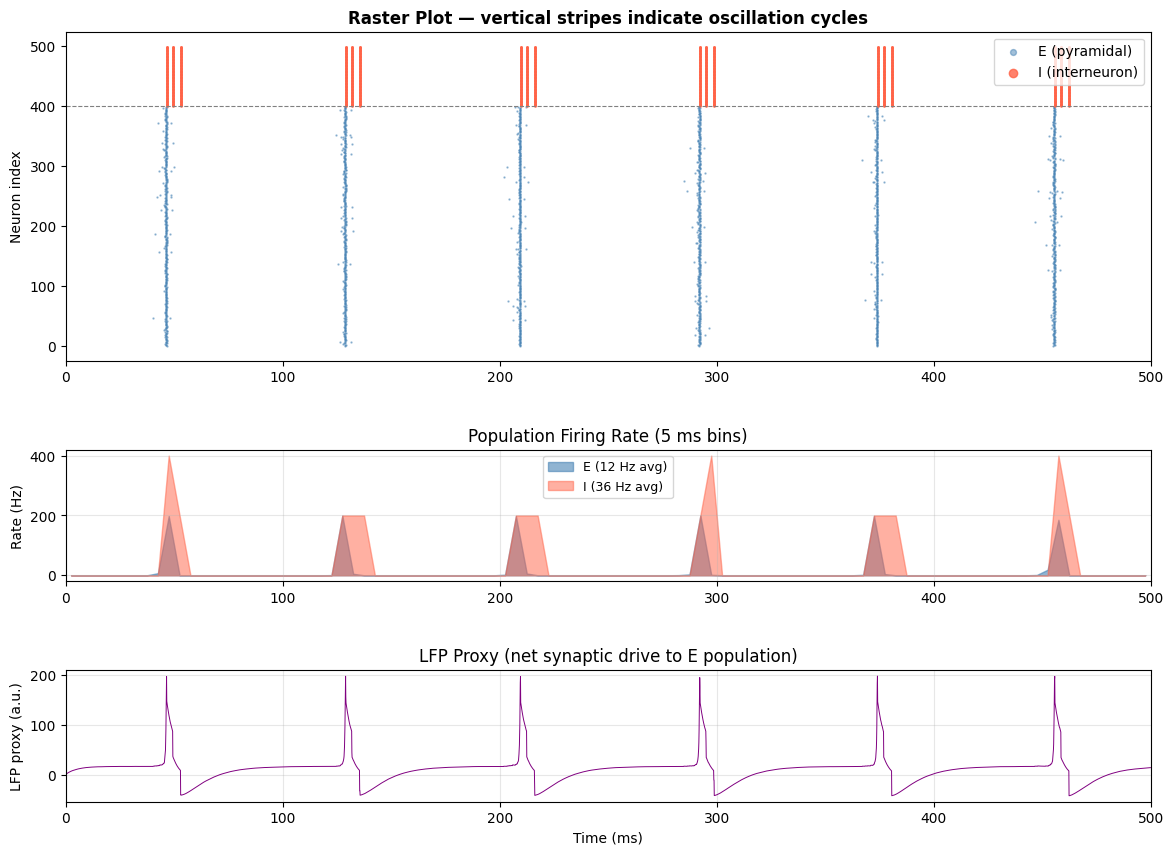

In [4]:
def pop_rate(sp_t, sp_n, mask, N_pop, bin_ms=5):
    bins = np.arange(0, T + bin_ms, bin_ms)
    spk  = sp_t[mask] if mask.any() else np.array([])
    counts, _ = np.histogram(spk, bins=bins)
    return (bins[:-1] + bins[1:]) / 2, counts / (N_pop * bin_ms / 1000)

e_mask = sp_n < N_E
i_mask = sp_n >= N_E
bc_e, rate_e = pop_rate(sp_t, sp_n, e_mask, N_E)
bc_i, rate_i = pop_rate(sp_t, sp_n, i_mask, N_I)

fig = plt.figure(figsize=(14, 10))
gs  = gridspec.GridSpec(3, 1, height_ratios=[3, 1.2, 1.2], hspace=0.45)

ax0 = fig.add_subplot(gs[0])
if e_mask.any(): ax0.scatter(sp_t[e_mask], sp_n[e_mask], s=0.5, color='steelblue', alpha=0.5, label='E (pyramidal)')
if i_mask.any(): ax0.scatter(sp_t[i_mask], sp_n[i_mask], s=1.0, color='tomato',    alpha=0.8, label='I (interneuron)')
ax0.axhline(N_E, color='gray', lw=0.8, linestyle='--')
ax0.set_ylabel('Neuron index')
ax0.set_title('Raster Plot — vertical stripes indicate oscillation cycles', fontweight='bold')
ax0.legend(loc='upper right', markerscale=6, fontsize=10)
ax0.set_xlim(0, T)

ax1 = fig.add_subplot(gs[1])
ax1.fill_between(bc_e, rate_e, alpha=0.6, color='steelblue', label=f'E ({e_rate:.0f} Hz avg)')
ax1.fill_between(bc_i, rate_i, alpha=0.5, color='tomato',    label=f'I ({i_rate:.0f} Hz avg)')
ax1.set_ylabel('Rate (Hz)')
ax1.set_title('Population Firing Rate (5 ms bins)')
ax1.legend(fontsize=9)
ax1.set_xlim(0, T)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[2])
ax2.plot(t_arr, LFP, color='purple', lw=0.7)
ax2.set_ylabel('LFP proxy (a.u.)')
ax2.set_xlabel('Time (ms)')
ax2.set_title('LFP Proxy (net synaptic drive to E population)')
ax2.set_xlim(0, T)
ax2.grid(alpha=0.3)

plt.savefig('raster_population.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Power Spectral Density

A peak in the PSD identifies the dominant oscillation frequency set by the E-I loop.

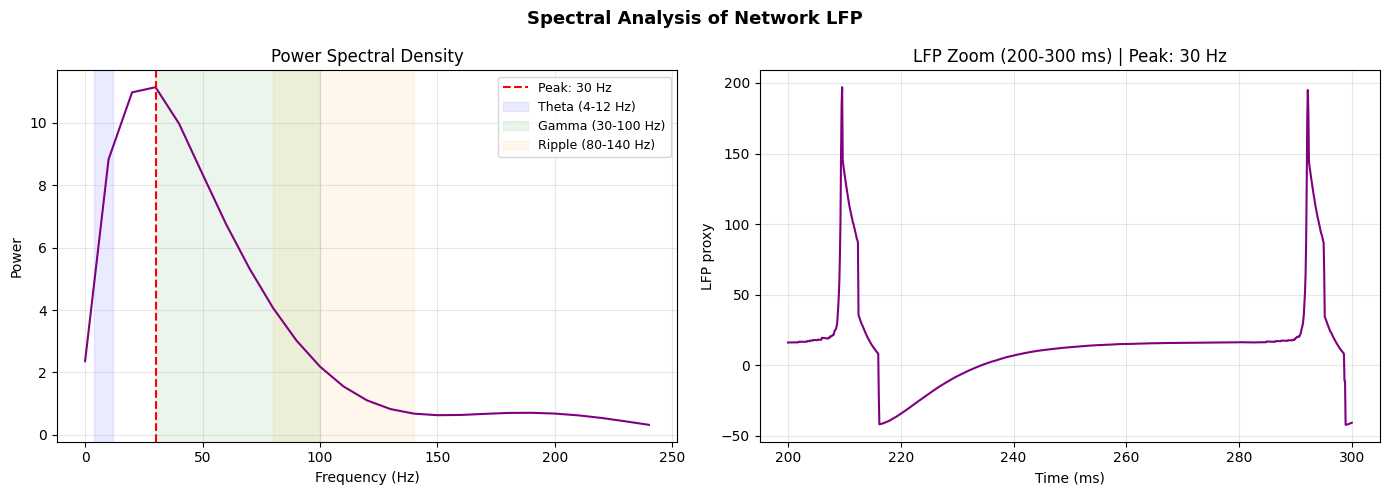

Dominant oscillation frequency: 30 Hz


In [5]:
freqs, psd = welch(LFP, fs=fs, nperseg=int(fs * 0.1), noverlap=int(fs * 0.05))
fm = (freqs > 5) & (freqs < 250)
peak_freq = freqs[fm][np.argmax(psd[fm])] if psd[fm].max() > 0 else 0

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Spectral Analysis of Network LFP', fontsize=13, fontweight='bold')

axes[0].plot(freqs[freqs < 250], psd[freqs < 250], color='purple', lw=1.5)
if peak_freq > 0:
    axes[0].axvline(peak_freq, color='red', linestyle='--', lw=1.5, label=f'Peak: {peak_freq:.0f} Hz')
axes[0].axvspan(4,   12,  alpha=0.08, color='blue',   label='Theta (4-12 Hz)')
axes[0].axvspan(30,  100, alpha=0.08, color='green',  label='Gamma (30-100 Hz)')
axes[0].axvspan(80,  140, alpha=0.08, color='orange', label='Ripple (80-140 Hz)')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power')
axes[0].set_title('Power Spectral Density')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

zm = (t_arr >= 200) & (t_arr <= 300)
axes[1].plot(t_arr[zm], LFP[zm], color='purple', lw=1.5)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('LFP proxy')
axes[1].set_title(f'LFP Zoom (200-300 ms) | Peak: {peak_freq:.0f} Hz')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('power_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Dominant oscillation frequency: {peak_freq:.0f} Hz")

## 6. E-I Balance Scan

Systematically varying w_IE reveals how inhibitory strength controls the oscillation frequency — a key question in hippocampal SWR research.

Scanning inhibitory feedback strength w_IE...
  w_IE=0.1: E=259 Hz, I=382 Hz, peak=10 Hz
  w_IE=0.2: E=219 Hz, I=372 Hz, peak=10 Hz
  w_IE=0.3: E=14 Hz, I=47 Hz, peak=30 Hz
  w_IE=0.5: E=12 Hz, I=36 Hz, peak=30 Hz
  w_IE=0.7: E=12 Hz, I=36 Hz, peak=10 Hz
  w_IE=1.0: E=12 Hz, I=36 Hz, peak=10 Hz
  w_IE=1.5: E=10 Hz, I=30 Hz, peak=10 Hz
  w_IE=2.0: E=10 Hz, I=30 Hz, peak=10 Hz


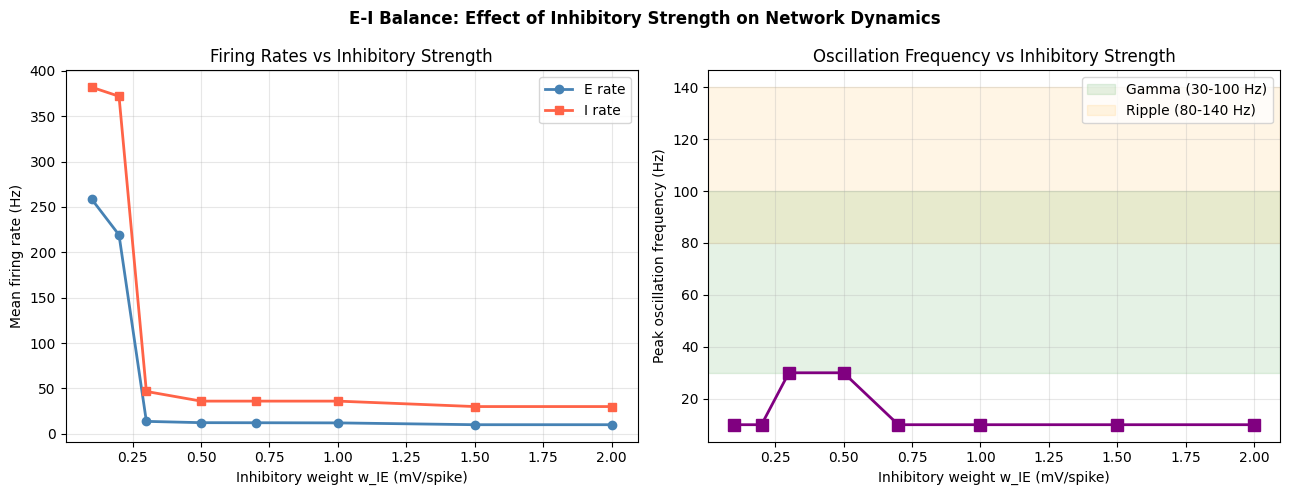

In [6]:
print("Scanning inhibitory feedback strength w_IE...")
w_IE_scan = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
results = []

for w_ie in w_IE_scan:
    st, sn, lfp = simulate(w_IE=w_ie)
    er = float((sn < N_E).sum())  / (N_E * dur_s) if len(sn) else 0
    ir = float((sn >= N_E).sum()) / (N_I * dur_s) if len(sn) else 0
    fw, pw = welch(lfp, fs=fs, nperseg=int(fs * 0.1))
    fm2 = (fw > 5) & (fw < 250)
    pf  = fw[fm2][np.argmax(pw[fm2])] if pw[fm2].max() > 0 else 0
    results.append({'w': w_ie, 'er': er, 'ir': ir, 'pf': pf})
    print(f"  w_IE={w_ie:.1f}: E={er:.0f} Hz, I={ir:.0f} Hz, peak={pf:.0f} Hz")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('E-I Balance: Effect of Inhibitory Strength on Network Dynamics',
             fontsize=12, fontweight='bold')

ws = [r['w'] for r in results]
axes[0].plot(ws, [r['er'] for r in results], 'o-', color='steelblue', lw=2, label='E rate')
axes[0].plot(ws, [r['ir'] for r in results], 's-', color='tomato',    lw=2, label='I rate')
axes[0].set_xlabel('Inhibitory weight w_IE (mV/spike)')
axes[0].set_ylabel('Mean firing rate (Hz)')
axes[0].set_title('Firing Rates vs Inhibitory Strength')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(ws, [r['pf'] for r in results], 's-', color='purple', lw=2, markersize=8)
axes[1].axhspan(30,  100, alpha=0.1, color='green',  label='Gamma (30-100 Hz)')
axes[1].axhspan(80,  140, alpha=0.1, color='orange', label='Ripple (80-140 Hz)')
axes[1].set_xlabel('Inhibitory weight w_IE (mV/spike)')
axes[1].set_ylabel('Peak oscillation frequency (Hz)')
axes[1].set_title('Oscillation Frequency vs Inhibitory Strength')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ei_balance_scan.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Sharp-Wave Ripple Analogue

Hippocampal SWRs consist of:
- A **sharp wave** (~50-150 ms envelope): arising from CA3 recurrent excitation spreading to CA1
- A **ripple** (~80-140 Hz): fast E-I oscillation riding on the sharp wave

We mimic this by injecting a transient Poisson burst to the E population and comparing the LFP during vs outside the burst window.

Running SWR-like simulation...
Done. Total spikes: 4257
Overall E rate: 12.3 Hz


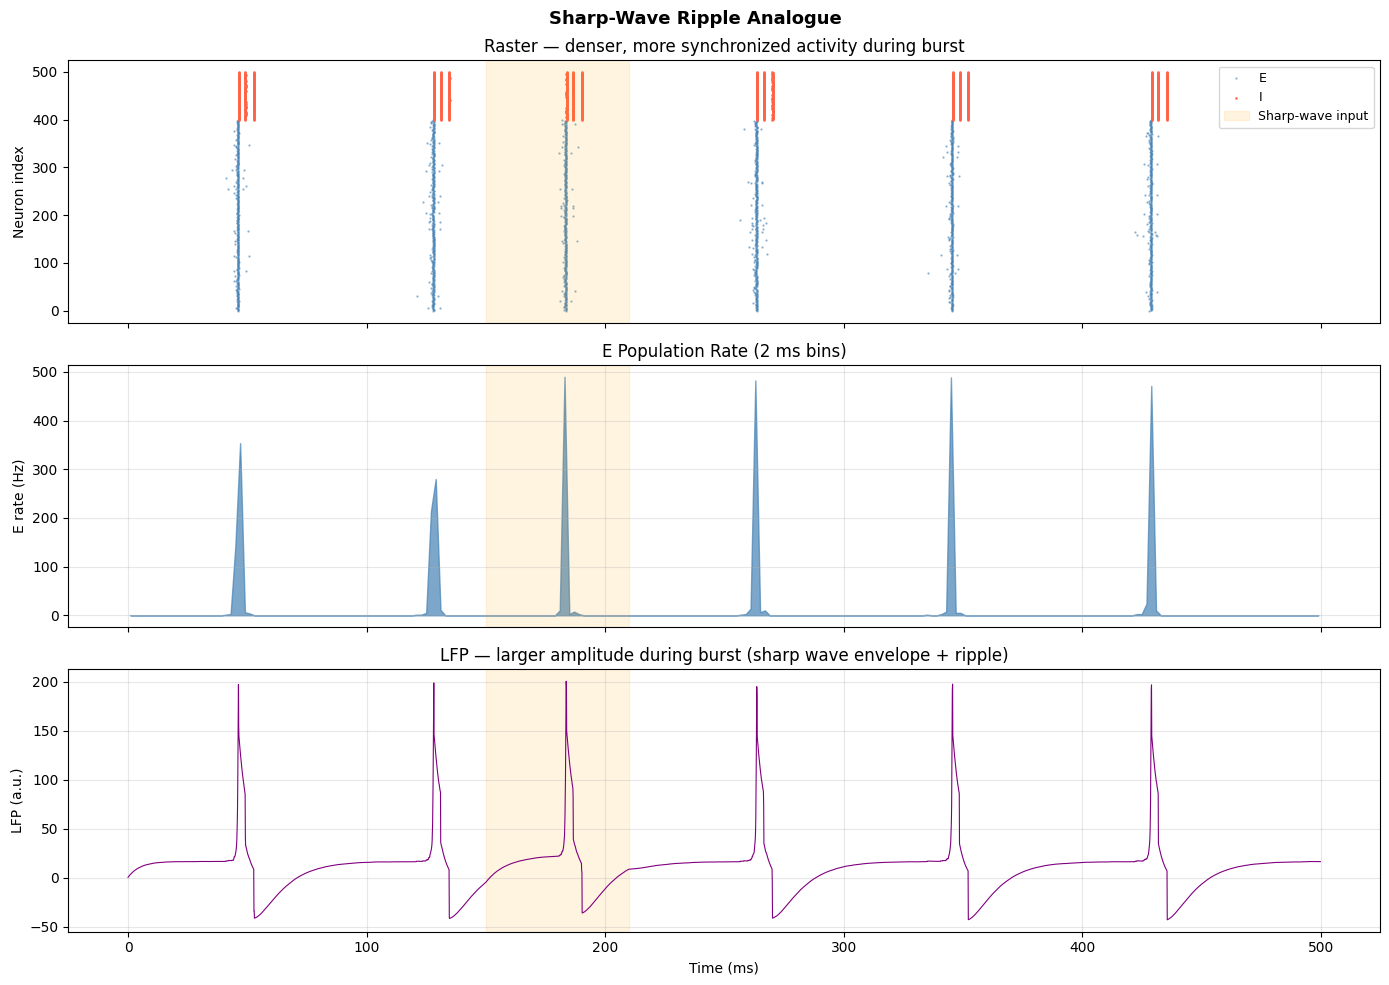

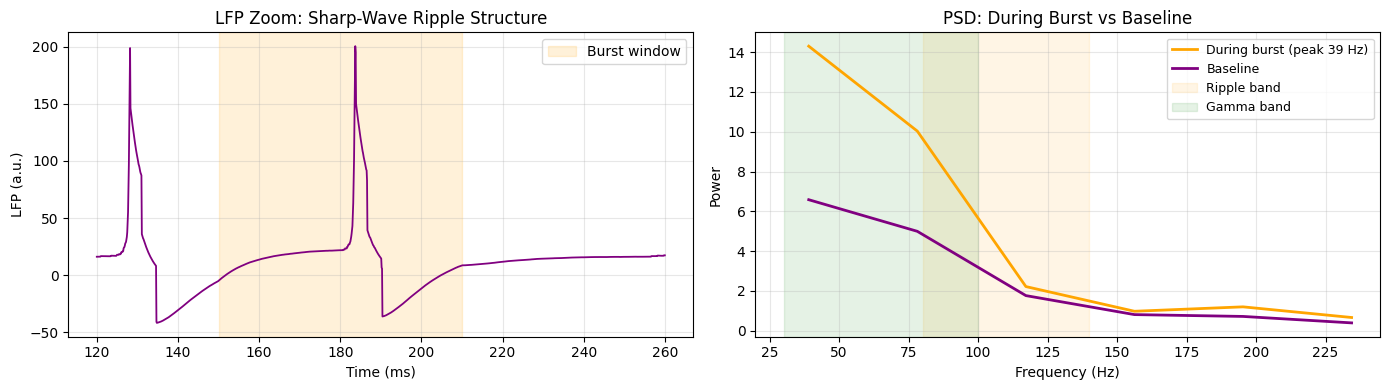

Peak frequency during burst: 39 Hz


In [7]:
print("Running SWR-like simulation...")
sp_ts, sp_ns, LFP_s = simulate(
    burst_onset=150.0, burst_duration=60.0, burst_extra_rate=2000.0
)
print(f"Done. Total spikes: {len(sp_ts)}")
e_rs = float((sp_ns < N_E).sum()) / (N_E * dur_s) if len(sp_ns) else 0
print(f"Overall E rate: {e_rs:.1f} Hz")

e_ms = sp_ns < N_E
i_ms = sp_ns >= N_E
bc2, rate2 = pop_rate(sp_ts, sp_ns, e_ms, N_E, bin_ms=2)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Sharp-Wave Ripple Analogue', fontsize=13, fontweight='bold')

if e_ms.any(): axes[0].scatter(sp_ts[e_ms], sp_ns[e_ms], s=0.5, color='steelblue', alpha=0.5, label='E')
if i_ms.any(): axes[0].scatter(sp_ts[i_ms], sp_ns[i_ms], s=1.0, color='tomato',    alpha=0.8, label='I')
axes[0].axvspan(150, 210, alpha=0.12, color='orange', label='Sharp-wave input')
axes[0].set_ylabel('Neuron index')
axes[0].set_title('Raster — denser, more synchronized activity during burst')
axes[0].legend(fontsize=9)

axes[1].fill_between(bc2, rate2, alpha=0.7, color='steelblue')
axes[1].axvspan(150, 210, alpha=0.12, color='orange')
axes[1].set_ylabel('E rate (Hz)')
axes[1].set_title('E Population Rate (2 ms bins)')
axes[1].grid(alpha=0.3)

axes[2].plot(t_arr, LFP_s, color='purple', lw=0.8)
axes[2].axvspan(150, 210, alpha=0.12, color='orange')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('LFP (a.u.)')
axes[2].set_title('LFP — larger amplitude during burst (sharp wave envelope + ripple)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('swr_analogue.png', dpi=150, bbox_inches='tight')
plt.show()

# Compare PSD inside vs outside burst
burst_win = (t_arr >= 150) & (t_arr <= 210)
base_win  = (t_arr >= 300) & (t_arr <= 450)

fw_b, pw_b = welch(LFP_s[burst_win], fs=fs, nperseg=min(256, burst_win.sum()//2))
fw_r, pw_r = welch(LFP_s[base_win],  fs=fs, nperseg=min(256, base_win.sum()//2))
fm_b = (fw_b > 5) & (fw_b < 250)
pf_b = fw_b[fm_b][np.argmax(pw_b[fm_b])] if pw_b[fm_b].max() > 0 else 0

fig, axes2 = plt.subplots(1, 2, figsize=(14, 4))
# Zoom of LFP
zm = (t_arr >= 120) & (t_arr <= 260)
axes2[0].plot(t_arr[zm], LFP_s[zm], color='purple', lw=1.3)
axes2[0].axvspan(150, 210, alpha=0.15, color='orange', label='Burst window')
axes2[0].set_xlabel('Time (ms)')
axes2[0].set_ylabel('LFP (a.u.)')
axes2[0].set_title('LFP Zoom: Sharp-Wave Ripple Structure')
axes2[0].legend()
axes2[0].grid(alpha=0.3)

# PSD comparison
axes2[1].plot(fw_b[fm_b], pw_b[fm_b], color='orange', lw=2, label=f'During burst (peak {pf_b:.0f} Hz)')
axes2[1].plot(fw_r[fm_b], pw_r[fm_b], color='purple', lw=2, label='Baseline')
axes2[1].axvspan(80, 140, alpha=0.1, color='orange', label='Ripple band')
axes2[1].axvspan(30, 100, alpha=0.1, color='green',  label='Gamma band')
axes2[1].set_xlabel('Frequency (Hz)')
axes2[1].set_ylabel('Power')
axes2[1].set_title('PSD: During Burst vs Baseline')
axes2[1].legend(fontsize=9)
axes2[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('swr_psd.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Peak frequency during burst: {pf_b:.0f} Hz")

## Summary

This notebook demonstrated:

1. **Spontaneous E-I oscillations** emerge from the E→I→E feedback loop without any external oscillatory drive (PING mechanism)
2. **E-I balance controls frequency**: stronger inhibition changes the oscillation frequency — the inhibitory time constant $\tau_I$ sets the cycle length
3. **Sharp-wave ripple analogue**: a transient excitatory burst triggers increased population synchrony with faster oscillations, qualitatively matching hippocampal SWR structure during sleep

This notebook provides the conceptual and computational foundation for building the biophysically detailed CA3 models that answer those questions.

---
## References
- Buzsaki G. (2015). Hippocampal sharp wave-ripple. *Hippocampus* 25(10), 1073-1188.
- Whittington et al. (1995). Synchronized oscillations driven by mGluR activation. *Nature* 373.
- Brunel N. (2000). Dynamics of sparsely connected networks. *J. Comp. Neurosci.* 8, 183-208.
- Dayan & Abbott (2001). *Theoretical Neuroscience*. MIT Press, Ch. 7.